# Analysing Different Methods of Finding $Q^2$ and $x$

## Finding $x$ and $Q^2$ using eletron scattering and the final hadronic state

In [2]:
import numpy as np
import uproot as ur
import awkward as ak
import matplotlib.pyplot as plt
# 18X275 or 5x41
E, Ep = 5, 41
s = 4 * E * Ep
xe, xjb, xdiff, epz = [], [], [], []


eAngle, eEnergy, epz, pth = [], [], [], []

Q2e, Q2jb = [],[]
fileCount = 5

# indexes of x we used
indexes = [[] for i in range(fileCount)]

# get data from file

files = list(f'../../data/pythia8NCDIS_{E}x{Ep}_minQ2=10_beamEffects_xAngle=-0.025_hiDiv_1.084{i}.eicrecon.tree.edm4eic.root' for i in range(fileCount))

for f, file_path in enumerate(files):
    events = ur.open(file_path + ':events')
    reconstructed_charged_particles = events['ReconstructedChargedParticles'].arrays()

    # loop through events to find electrons and store their momentum
    for i, event in  enumerate(reconstructed_charged_particles['ReconstructedChargedParticles.PDG']):
        eh, pzh, pyh, pxh, hadrons = 0, 0, 0, 0, 0
        
        xevent = []
        Q2event = []

        angleEvents = []
        energyEvents = []
        
        # if its just an electron, remove it
        if 1 == len(event):
            continue

        
        for j, particle in  enumerate(event):
            # if its an electron, find with scattered electron method
            if particle == 11:
                
                
                m = reconstructed_charged_particles['ReconstructedChargedParticles.mass'][i][j]
                kp1, kp2, kp3 = reconstructed_charged_particles['ReconstructedChargedParticles.momentum.x'][i][j], reconstructed_charged_particles['ReconstructedChargedParticles.momentum.y'][i][j], reconstructed_charged_particles['ReconstructedChargedParticles.momentum.z'][i][j]
                
                # check psuedo-rapidity
                kp = np.sqrt(kp1**2 + kp2**2 + kp3**2)
                theta = np.arccos(kp3/kp)
                pr = -np.log(np.tan(theta / 2))
                
                # remove particles with -4 < psuedo-rapidity < 4
                if abs(pr) < 4:

                    theta = np.arctan2(np.sqrt(kp1**2 + kp2**2), kp3)

                    k3 = -E
                    m0 = 0.000511
                    kp0 = np.sqrt(m0**2+(kp1**2+kp2**2+kp3**2))
                    k0 = np.sqrt(m0**2 + k3**2)
                    q0 = k0 - kp0
                    q1 =    - kp1
                    q2 =    - kp2
                    q3 = k3 - kp3
                    Q2 =-(q0**2 - q1**2 - q2**2 - q3**2) 
                    Q2event.append(Q2)


                    alpha = -0.025
                    p1 = Ep * np.sin(alpha)
                    p2 = 0
                    p3 = Ep * np.cos(alpha)
                    p0 = np.sqrt(0.938**2 + p1**2 + p2**2 + p3**2)
                    pq = p0 * q0 - p1 * q1 - p2 * q2 - p3 * q3
                    xevent.append(0.5 * Q2 / pq)
                    energyEvents.append(kp0)
                    angleEvents.append(theta)

                    
                    
                    
            # get the sum of components from hadrons for JB method
            elif abs(particle) == 211 or abs(particle) == 321 or particle == 2212:
                
                
                m = reconstructed_charged_particles['ReconstructedChargedParticles.mass'][i][j]
                kp1, kp2, kp3 = reconstructed_charged_particles['ReconstructedChargedParticles.momentum.x'][i][j], reconstructed_charged_particles['ReconstructedChargedParticles.momentum.y'][i][j], reconstructed_charged_particles['ReconstructedChargedParticles.momentum.z'][i][j]
                
                
                kp = np.sqrt(kp1**2 + kp2**2 + kp3**2)
                theta = np.arccos(kp3/kp)
                pr = -np.log(np.tan(theta / 2))
                
                if abs(pr) < 4:
                    hadrons += 1
                    eh  += np.sqrt(m**2+(kp1**2+kp2**2+kp3**2))
                    pxh += kp1
                    pyh += kp2
                    pzh += kp3
                
        
        # add one per event
        y = 1/(2 * E) * (eh - pzh)
        Q2 = 1/(1 - y) * (pxh**2 + pyh**2)
        
        if hadrons != 0 and len(Q2event) != 0:
            indexes[f].append(i)
            epz.append((eh - pzh))
            pth.append((pxh**2 + pyh**2))
            eAngle.append(angleEvents[Q2event.index(max(Q2event))])
            eEnergy.append(energyEvents[Q2event.index(max(Q2event))])


            xjb.append(Q2 / (s * y))
            xe.append(xevent[Q2event.index(max(Q2event))])

            Q2jb.append(Q2)
            Q2e.append(max(Q2event))



## Finding the true $x$ and $Q^2$

In [86]:
mc_particles = events['MCParticles'].arrays()

Q2true, xtrue, ytrue = [], [], []
# loop through all the indexes we got the other values from so we skip the same events
for lst  in indexes:
    for i in lst:
        event = mc_particles['MCParticles.PDG'][i]
        Q2tot, xtot, ytot = [], [], []
        for j, particle in enumerate(event):
            if mc_particles['MCParticles.generatorStatus'][i][j] != 1 or particle != 11:
                continue
            
            psx, psy, psz = mc_particles['MCParticles.momentum.x'][i][j], mc_particles['MCParticles.momentum.y'][i][j], mc_particles['MCParticles.momentum.z'][i][j]
            Eproton = np.sqrt(0.000511**2 + psx**2 + psy**2 + psz**2)
            theta = np.arctan2(np.sqrt(psx**2 + psy**2), psz)
            
            Q2 = 2 * E * Eproton * (1 + np.cos(theta))
            
            y = 1 - 0.5 * Eproton / E * (1 - np.cos(theta))
            x = Q2 / s / y
            xtot.append(x)
            Q2tot.append(Q2)
            ytot.append(x)

        # if we have multiple events, use one with largest Q2
        if len(xtot) > 0:
            xtrue.append(xtot[Q2tot.index(max(Q2tot))])
            ytrue.append(ytot[Q2tot.index(max(Q2tot))])
            Q2true.append(max(Q2tot))

print(len(xtrue))

5085


In [3]:
import math

for i in range(len(xtrue)):
    q2 = 2 * eEnergy[i] * E * (1 + math.cos(eAngle[i]))
    y = (1/2/E) * epz[i]
    q3 = 1/(1 - y) * pth[i]


## Training Artificial Neural Network

### ANN Neurolab

#### X

In [96]:
import neurolab as nl

# TODO: scale data, try different functions, relu, tan, tansig, import more data

def normalization(x, minimax):
    n = len(x[0])
    print(n)
    for i in range(n):
        mn, mx = minimax[i]
        for j in range(len(x)):

            x[j][i] = (x[j][i] - mn) / (mx - mn)


# Create the input and target data
x_train = []
y_train = []

x_test = []
y_test = []


trainingData = int(len(Q2true) * 3/4)
testingData = len(Q2true) - trainingData

for i in range(trainingData):
    x_train.append([eAngle[i].item(), 
            eEnergy[i].item(),
            pth[i].item(),
            epz[i].item()])

    y_train.append([xtrue[i]])

for i in range(trainingData, len(Q2true)):
    x_test.append([eAngle[i].item(), 
            eEnergy[i].item(),
            pth[i].item(),
            epz[i].item()])

    y_test.append([xtrue[i]])

minmax = [[min(eAngle), max(eAngle)], [min(eEnergy), max(eEnergy)], [min(pth), max(pth)], [min(epz), max(epz)]]
normalization(x_train, minmax)
normalization(x_test, minmax)

# Create the neural network
net = nl.net.newff([[0,1], [0,1], [0,1],[0,1]], [24, 24, 1])
net.init()



# Train the neural network

print("Training...")
accuracies = net.train(x_train, y_train, epochs=3, show = 1, goal = 0.02)

# Test the neural network
print("Testing...")
output = net.sim(x_test)

# Print the output

aiTrueX = []
aiOPX = []

for i in range(len(output)):
    aiOPX.append(output[i][0])
    aiTrueX.append(y_train[i][0])

    

4
4
Training...
Epoch: 1; Error: 60.353504139789294;
Epoch: 2; Error: 48.92616734061937;
Epoch: 3; Error: 43.7970814024208;
The maximum number of train epochs is reached
Testing...


#### Y

In [98]:
import neurolab as nl


def normalization(x, minimax):
    n = len(x[0])
    print(n)
    for i in range(n):
        mn, mx = minimax[i]
        for j in range(len(x)):

            x[j][i] = (x[j][i] - mn) / (mx - mn)




# Create the input and target data
x_train = []
y_train = []

x_test = []
y_test = []


trainingData = int(len(Q2true) * 3/4)
testingData = len(Q2true) - trainingData

for i in range(trainingData):
    x_train.append([eAngle[i].item(), 
            eEnergy[i].item(),
            pth[i].item(),
            epz[i].item()])

    y_train.append([ytrue[i]])

for i in range(trainingData, len(Q2true)):
    x_test.append([eAngle[i].item(), 
            eEnergy[i].item(),
            pth[i].item(),
            epz[i].item()])

    y_test.append([ytrue[i]])

minmax = [[min(eAngle), max(eAngle)], [min(eEnergy), max(eEnergy)], [min(pth), max(pth)], [min(epz), max(epz)]]

normalization(x_train, minmax)
normalization(x_test, minmax)

# Create the neural network
net = nl.net.newff([[0,1], [0,1], [0,1],[0,1]], [24, 24, 1])


net.init()

# Train the neural network

print("Training...")
accuracies = net.train(x_train, y_train, epochs=3, show = 1, goal = 0.02)


# Test the neural network
print("Testing...")
output = net.sim(x_test)

# Print the output

aiTrueY = []
aiOPY = []

for i in range(len(output)):
    aiOPY.append(output[i][0])
    aiTrueY.append(y_train[i][0])

4
4
Training...
Epoch: 1; Error: 74.55383941472455;
Epoch: 2; Error: 54.14216447437731;
Epoch: 3; Error: 52.26319575269707;
The maximum number of train epochs is reached
Testing...


In [97]:
net = nl.net.newff([[0,1], [0,1], [0,1],[0,1]], [24, 24, 1])
net.layers[0].transf = nl.trans.LogSig()
net.layers[1].transf = nl.trans.LogSig()
net.layers[2].transf = nl.trans.LogSig()

net.init()

# Train the neural network

print("Training...")
logaccuracies = net.train(x_train, y_train, epochs=12, show = 1, goal = 0.02)

Training...
Epoch: 1; Error: 37.34840867903503;
Epoch: 2; Error: 37.072457796607026;
Epoch: 3; Error: 36.95053325428484;
Epoch: 4; Error: 36.85384820514972;
Epoch: 5; Error: 36.848264351743936;
Epoch: 6; Error: 36.84582369878921;
Epoch: 7; Error: 36.843791012458325;
Epoch: 8; Error: 36.84162545747692;
Epoch: 9; Error: 36.839705754874714;
Epoch: 10; Error: 36.83924366663523;
Epoch: 11; Error: 36.83904170785403;
Epoch: 12; Error: 36.8386788956697;
The maximum number of train epochs is reached


Text(0, 0.5, 'Percent Error')

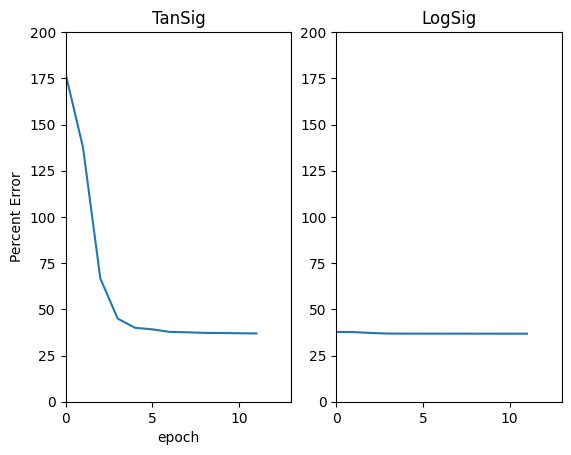

In [38]:



fig2, plots =  plt.subplots(nrows=1, ncols=2)

plots[0].plot(accuracies)
plots[0].set_title("TanSig")
plots[0].axis([0, 13,0, 200,])

plots[1].axis([0, 13,0, 200,])
plots[1].set_title("LogSig")
plots[1].plot(logaccuracies)
plots[0].set_xlabel("epoch")
plots[0].set_ylabel("Percent Error")


In [1]:
x_bins = np.logspace(-4, 0, 30) # specify exponents of 10
Q2_bins = np.logspace(0, 3, 40) # specify exponents of 10


plt.hist2d(aiOPX, aiTrueX, bins = [x_bins, x_bins],cmin = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$x_{ai}$')
plt.ylabel('$x_{true}$')

NameError: name 'np' is not defined

Text(0, 0.5, '$y_{true}$')

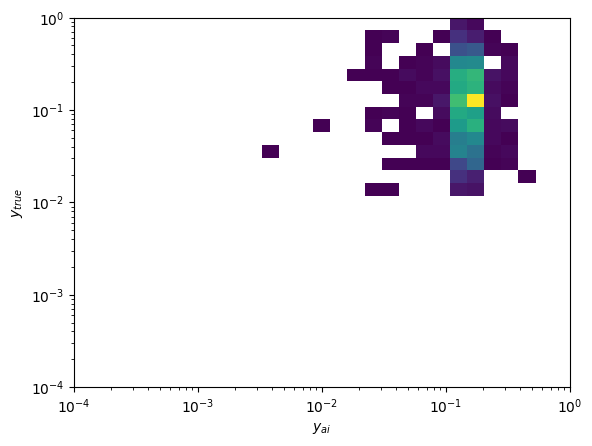

In [43]:
x_bins = np.logspace(-4, 0, 30) # specify exponents of 10
Q2_bins = np.logspace(0, 3, 40) # specify exponents of 10


plt.hist2d(aiOPY, aiTrueY, bins = [x_bins, x_bins],cmin = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$y_{ai}$')
plt.ylabel('$y_{true}$')

In [3]:
aiOPQ2 = []
aiTrueQ2 = []

for i in range(len(aiOPY)):
    q2 = aiOPY[i] * aiOPX[i] * s
    aiOPQ2.append(q2)
    aiTrueQ2.append(Q2true[trainingData + i])

x_bins = np.logspace(-4, 0, 30) # specify exponents of 10
Q2_bins = np.logspace(0, 3, 40) # specify exponents of 10


plt.hist2d(aiOPQ2, aiTrueQ2, bins = [Q2_bins, Q2_bins],cmin = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$Q^2_{ai}$')
plt.ylabel('$Q^2_{true}$')

NameError: name 'aiOPY' is not defined